<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Market-Based Valuation of Equity Options

### A Python-based Journey

Dr Yves J Hilpisch

The Python Quants GmbH

**CQF Lecture, 20. September 2018, London**

In [1]:
import warnings
warnings.simplefilter('ignore')

## About TPQ & Me

<img src="http://hilpisch.com/images/tpq_overview.png" width="60%">

<img src="http://hilpisch.com/images/pqp_info.png" width="60%">

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width=300px>

<img src="http://hilpisch.com/images/derivatives_analytics_front.jpg" width=300px>

<img src="http://hilpisch.com/images/lvvd_cover.png" width=300px>

<img src="http://hilpisch.com/images/algo_brochure_low_shadow.png" width=800px>

I organize a number of **events** and **training programs**.

* For Python Quants Bootcamp (with CQF Institute) &mdash; [http://fpq.io](http://fpq.io)
* Python for Quant Finance Meetup Group London &mdash; [http://pqf.tpq.io](http://pqf.tpq.io)
* University Certificate in Python for Algorithmic Trading &mdash; [http://certificate.tpq.io](http://certificate.tpq.io)

More information and further links under [http://tpq.io](http://fpq.io) and [http://hilpisch.com](http://hilpisch.com). Follow me on Twitter [http://twitter.com/dyjh](http://twitter.com/dyjh)

## Agenda

* Benchmark Case of Normally Distributed Returns
* Market Stylized Facts about Index Prices and Equity Options
* (_Fourier-based Option Pricing_)
* **Basic Option Pricing with Python &mdash; Complete Markets**
* **Basic Option Pricing with Python &mdash; Incomplete Markets**
* Merton (1976) Jump-Diffusion Model
* Monte Carlo Simulation in the Merton (1976) Model
* Calibration of the Merton (1976) Model to Market Quotes

Go to [http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com) to find links to all the resources and Python codes (eg Quant Platform, Github repository).

## The Benchmark Case

Let us first set the stage with **standard normally distributed (pseudo-) random numbers** ...

In [2]:
import numpy as np
a = np.random.standard_normal(1000)

In [3]:
a.mean()

0.009115036193707866

In [4]:
a.std()

1.0297928074308704

... and a simulated **geometric Brownian motion** (GBM) path. We make the following assumptions.

In [5]:
import math
import pandas as pd
# model parameters
S0 = 100.0  # initial index level
T = 10.0  # time horizon
r = 0.05  # risk-less short rate
vol = 0.2  # instantaneous volatility

# simulation parameters
np.random.seed(250000)
gbm_dates = pd.DatetimeIndex(start='30-09-2004',
                             end='31-08-2015',
                             freq='B')
M = len(gbm_dates)  # time steps
dt = 1 / 252.  # fixed for simplicity
df = math.exp(-r * dt)  # discount factor

This **function** simulates GBM paths given the assumptions.

In [6]:
def simulate_gbm():
    # stock price paths
    rand = np.random.standard_normal((M, I))  # random numbers
    S = np.zeros_like(rand)  # stock matrix
    S[0] = S0  # initial values
    for t in range(1, M):  # stock price paths
        S[t] = S[t - 1] * np.exp((r - vol ** 2 / 2) * dt
                        + vol * rand[t] * math.sqrt(dt))

    gbm = pd.DataFrame(S[:, 0], index=gbm_dates, columns=['index'])
    gbm['returns'] = np.log(gbm['index'] / gbm['index'].shift(1))


    # Realized Volatility (eg. as defined for variance swaps)
    gbm['rea_var'] = 252 * np.cumsum(gbm['returns'] ** 2) / np.arange(len(gbm))
    gbm['rea_vol'] = np.sqrt(gbm['rea_var'])
    gbm = gbm.dropna()
    return gbm

Let us simulate a single path and inspect **major statistics**.

In [7]:
from gbm_helper import *
I = 1  # index level paths
gbm = simulate_gbm()
print_statistics(gbm)

RETURN SAMPLE STATISTICS
---------------------------------------------
Mean of Daily  Log Returns -0.000017
Std  of Daily  Log Returns  0.012761
Mean of Annua. Log Returns -0.004308
Std  of Annua. Log Returns  0.202578
---------------------------------------------
Skew of Sample Log Returns -0.037438
Skew Normal Test p-value    0.413718
---------------------------------------------
Kurt of Sample Log Returns  0.106754
Kurt Normal Test p-value    0.239124
---------------------------------------------
Normal Test p-value         0.358108
---------------------------------------------
Realized Volatility         0.202578
Realized Variance           0.041038


Simulated **prices and resulting log returns** visulized.

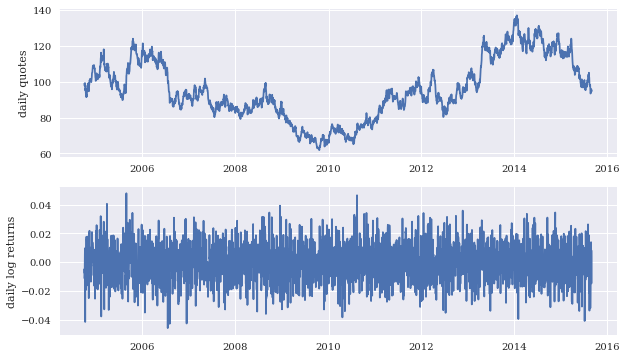

In [8]:
%matplotlib inline
quotes_returns(gbm)

A histogram of the **log returns compared to the normal distribution** (with same mean/std).

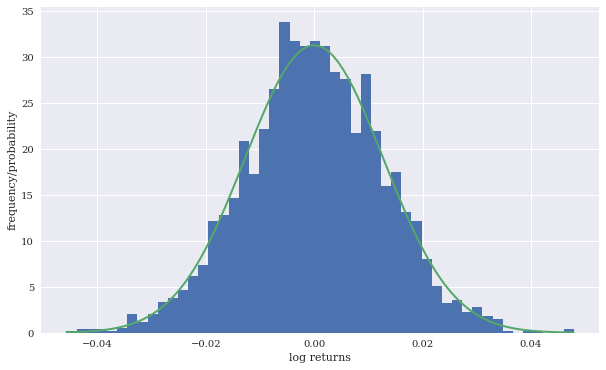

In [9]:
return_histogram(gbm)

And a Quantile-Quantile QQ-plot of the log returns.

<Figure size 720x432 with 0 Axes>

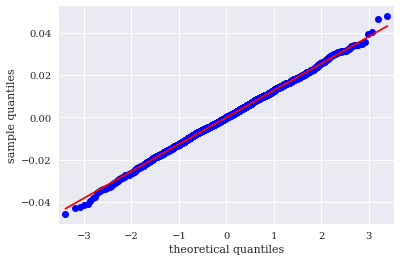

In [10]:
return_qqplot(gbm);

The **realized volatility** over time.

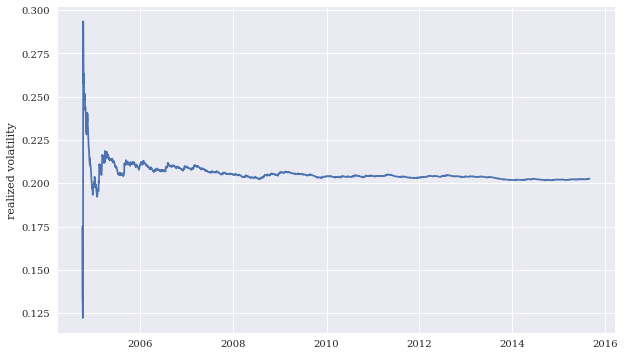

In [11]:
realized_volatility(gbm)

Some **rolling annualized statistics**.

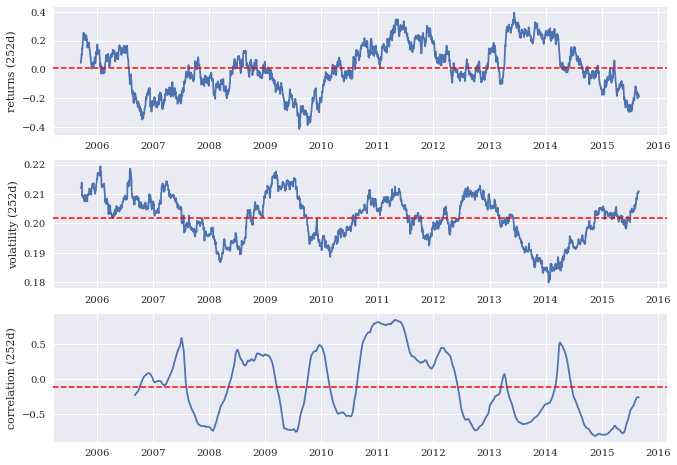

In [12]:
rolling_statistics(gbm)

## Market Stylized Facts

We work with **historical DAX data**. The following function equips us with the necessary time series data.

In [13]:
from urllib.request import urlretrieve

In [14]:
urlretrieve('http://hilpisch.com/equities.h5', 'equities.h5')

('equities.h5', <http.client.HTTPMessage at 0x1c1d749470>)

In [15]:
def read_dax_data():
    ''' Reads historical DAX data from Yahoo! Finance, calculates log returns, 
    realized variance and volatility.'''

    try:
        h5 = pd.HDFStore('equities.h5', 'r')
    except:
        from urllib.request import urlretrieve
        urlretrieve('http://hilpisch.com/equities.h5', 'equities.h5')
        h5 = pd.HDFStore('equities.h5', 'r')
    
    DAX = pd.DataFrame(h5['data']['^GDAXI'])
    DAX = DAX[(DAX.index >= '30-09-2004') & (DAX.index <= '31-08-2015')]
    DAX.rename(columns={'^GDAXI' : 'index'}, inplace=True)
    print(DAX.tail())
    DAX['returns'] = np.log(DAX['index'] / DAX['index'].shift(1))
    DAX['rea_var'] = 252 * np.cumsum(DAX['returns'] ** 2) / np.arange(len(DAX))
    DAX['rea_vol'] = np.sqrt(DAX['rea_var'])
    DAX = DAX.dropna()
    return DAX

Lets **retrieve and inspect** the data.

In [16]:
%time DAX = read_dax_data()

                   index
Date                    
2015-08-25  10128.120117
2015-08-26   9997.429688
2015-08-27  10315.620117
2015-08-28  10298.530273
2015-08-31  10259.459961
CPU times: user 299 ms, sys: 117 ms, total: 416 ms
Wall time: 555 ms


In [17]:
print_statistics(DAX)

RETURN SAMPLE STATISTICS
---------------------------------------------
Mean of Daily  Log Returns  0.000308
Std  of Daily  Log Returns  0.013992
Mean of Annua. Log Returns  0.077584
Std  of Annua. Log Returns  0.222112
---------------------------------------------
Skew of Sample Log Returns -0.001354
Skew Normal Test p-value    0.977037
---------------------------------------------
Kurt of Sample Log Returns  6.520355
Kurt Normal Test p-value    0.000000
---------------------------------------------
Normal Test p-value         0.000000
---------------------------------------------
Realized Volatility         0.220012
Realized Variance           0.048405


The (in-memory) **data structure**.

In [18]:
DAX.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2695 entries, 2004-10-01 to 2015-08-31
Data columns (total 4 columns):
index      2695 non-null float64
returns    2695 non-null float64
rea_var    2695 non-null float64
rea_vol    2695 non-null float64
dtypes: float64(4)
memory usage: 105.3 KB


In [19]:
DAX[['index', 'returns', 'rea_var', 'rea_vol']].tail()

,index,returns,rea_var,rea_vol
Date,,,,
2015-08-25,10128.120117,0.048521,0.048369,0.219929
2015-08-26,9997.429688,-0.012988,0.048367,0.219924
2015-08-27,10315.620117,0.031331,0.048439,0.220089
2015-08-28,10298.530273,-0.001658,0.048422,0.220049
2015-08-31,10259.459961,-0.003801,0.048405,0.220012


The **index levels and log returns**.

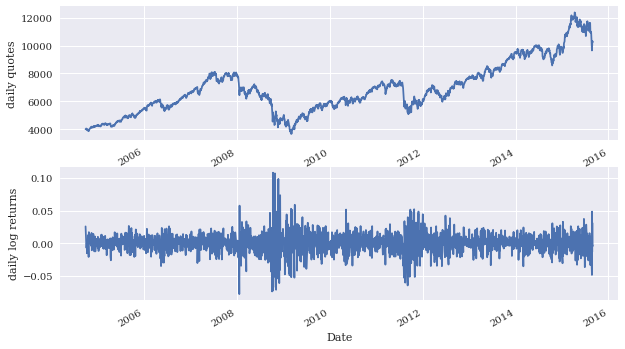

In [20]:
quotes_returns(DAX)

A histogram of the **log returns compared to the normal distribution** (with same mean/std).

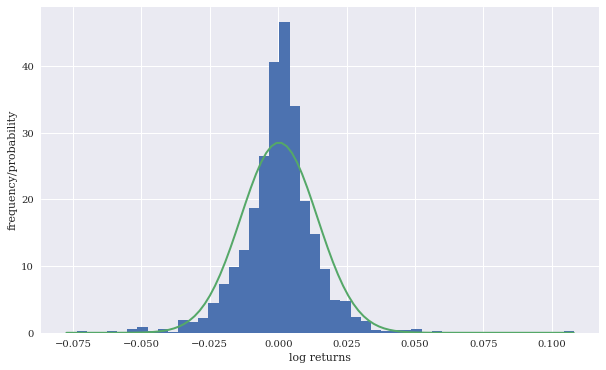

In [21]:
return_histogram(DAX)

The **QQ-plot**.

<Figure size 720x432 with 0 Axes>

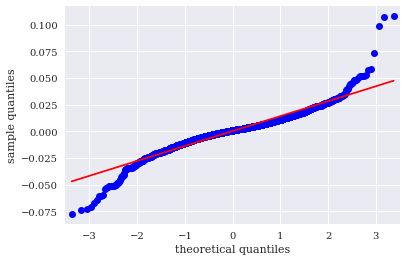

In [22]:
return_qqplot(DAX)

The **realized volatility**.

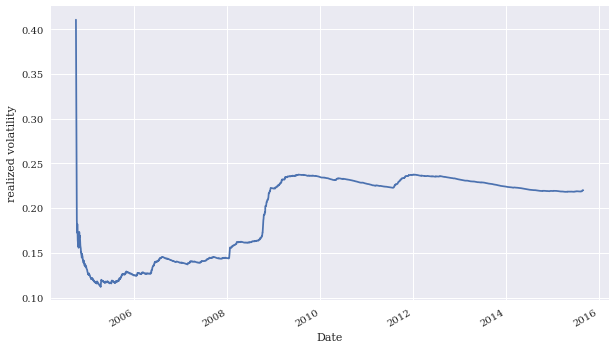

In [23]:
realized_volatility(DAX)

And finally the **rolling annualized statistics**.

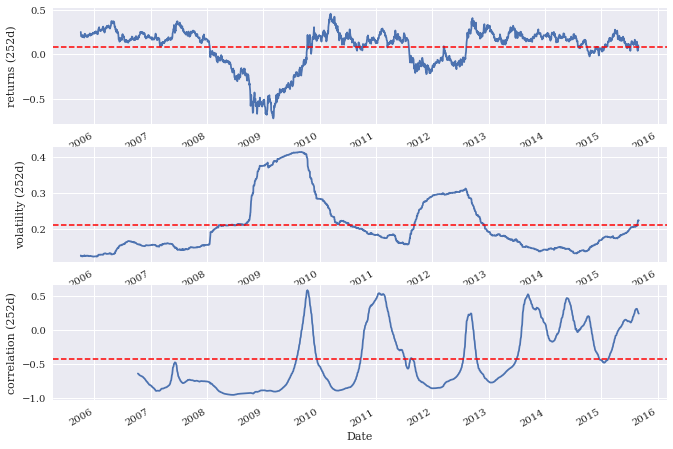

In [24]:
rolling_statistics(DAX)

Finally, we want to look for **jumps** (heuristically). We use this simple function.

In [25]:
def count_jumps(data, value):
    ''' Counts the number of return jumps as defined in size by value. '''
    jumps = np.sum(np.abs(data['returns']) > value)
    return jumps

We define a **jump** as a log return higher in absolute value than 0.05.

In [26]:
count_jumps(DAX, 0.05)  # "jumps" in the DAX index

31

In [27]:
count_jumps(gbm, 0.05)  # "jumps" in the GBM path

0

In a Gaussian setting we have

* negative jumps:

$$P(r_n < −0.05) = 0.0002911$$

* positive jumps:

$$P(r_n > +0.05) = 0.0003402$$

for the DAX index given a return observation $r_n$. In such a setting the number of return observations lower than $-0.05$ and higher than $+0.05$ would be expected to be:

In [28]:
0.0002911 * len(DAX)  # 'lower than -0.05'

0.7845144999999999

In [29]:
0.0003402 * len(DAX)  # 'higher than +0.05'

0.916839

In summary, we "discover" the following stylized facts:

* **stochastic volatility**: volatility is neither constant nor deterministic; there is no mechanism
to forecast volatility at a high confidence level
* **volatility clustering**: empirical data suggests that high volatility events seem to cluster
in time; there is often a positive autocorrelation of volatility measures
* **volatility mean reversion**: volatility is a mean-reverting quantity &mdash; it never reaches zero
nor does it go to infinity; however, the mean can change over time
* **leverage effect**: our data suggests that volatility is negatively correlated (on average) with asset returns; if return measures increase, volatility measures often decrease and vice versa
* **fat tails**: compared to a normal distribution large positive and negative index returns are
more frequent
* **jumps**: index levels may move by magnitudes that cannot be explained within a Gaussian,
i.e. normal, diffusion setting; some jump component may be necessary to explain certain
large moves

Important add-on topic: **volatility smiles and term structure** &mdash; here implied volatilities from European call options on the EURO STOXX 50 on 30. September 2014.

In [30]:
%run es50_imp_vol.py

<Figure size 432x288 with 0 Axes>

In [31]:
data.tail()

,Date,Strike,Call,Maturity,Put
498,2014-09-30,3750.0,27.4,2015-09-18,635.9
499,2014-09-30,3800.0,21.8,2015-09-18,680.3
500,2014-09-30,3850.0,17.2,2015-09-18,725.7
501,2014-09-30,3900.0,13.4,2015-09-18,772.0
502,2014-09-30,3950.0,10.4,2015-09-18,818.9


The calculation of the **implied volatilities** and the visualization.

In [32]:
%time imp_vols = calculate_imp_vols(data)

CPU times: user 22.2 s, sys: 183 ms, total: 22.4 s
Wall time: 23 s


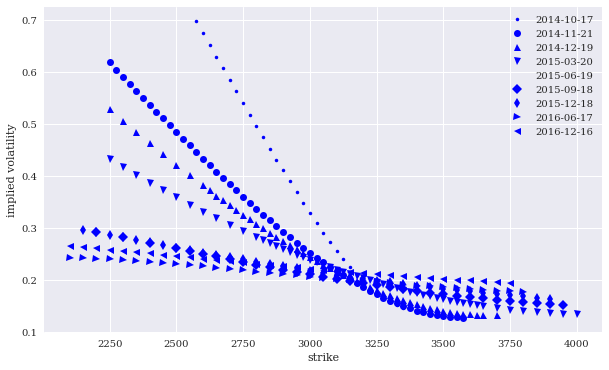

In [33]:
plot_imp_vols(data)

## Option Pricing with Python

Some live examples.

## Fourier-based Option Pricing

The Fourier-based option pricing approach has three main advantages:

* **generality**: the approach is applicable whenever the characteristic function of the process driving uncertainty is known; and this is the case for the majority of processes/models applied in practice
* **accuracy**: the semi-analytic formulas can be evaluated numerically in such a way that a high degree of accuracy is reached at little computational cost (e.g. compared to simulation techniques)
* **speed**: the formulas can in general be evaluated very fast such that 10s, 100s or even 1,000s of options can be valued per second

Let us start with a **market model** of the form:

$$
\mathcal{M} = \{(\Omega,\mathcal{F},\mathbb{F},P),T,(S,B)\}
$$

* $(\Omega,\mathcal{F},\mathbb{F},P)$ is a filtered probability space
* $T>0$ is a fixed time horizon
* $(S,B)$ are two traded assets, $S$ a risky one and $B$ a risk-less one

We then know that the **arbitrage value of an attainable European call option** is

$$
C_{t}=e^{-r(T-t)}\mathbf{E}^{Q}_{t}(C_{T})
$$

where $C_{T}\equiv\max[S_{T}-K,0]$ for a strike $K>0$. In integral from, setting $t=0$, call option pricing reads

$$
\begin{eqnarray}
C_{0}&=&e^{-rT}\int_{0}^{\infty} C_{T}(s) Q(ds) \nonumber\\
   &=&e^{-rT}\int_{0}^{\infty} C_{T}(s) q(s) ds
\end{eqnarray}
$$

where $q(s)$ is the risk-neutral probability density function (pdf) of $S_{T}$. Unfortunately, the pdf is quite often not known in closed form &mdash; whereas the characteristic function (CF) of $S_{T}$ is.

**The fundamental insight of Fourier-based option pricing is to replace both the pdf by the CF and the call option payoff $C_{T}$ by its Fourier transform.**

Let a random variable $X$ be distributed with pdf $q(x)$. The **characteristic function** $\hat{q}$ of $X$ is the Fourier transform of its pdf

$$
\hat{q}(u)\equiv \int_{-\infty}^{\infty}e^{iux} q(x) dx = \mathbf{E}^{Q}\left(e^{iuX}\right)
$$

For $u=u_{r}+iu_{i}$ with $u_{i}>1$, the **Fourier transform of the European call option payoff** $C_{T} = \max[S_T - K, 0]$is given by:

$$\widehat{C}_{T}(u)= -\frac{K^{iu+1}}{u^2-iu}$$

**Lewis (2001)**: With $\varphi$ as the CF of the rv $S_T$ and assuming $u_{i}\in (0,1)$, the call option present value is
$$
C_{0}=S_{0}-\frac{Ke^{-rT}}{2\pi}\int_{-\infty+iu_{i}}^{\infty+iu_{i}} e^{-iuk} \varphi(-u) \frac{du}{u^2-ui}
$$

Furthermore, setting $u_{i}=0.5$ gives

$$
C_{0}=S_{0}-\frac{\sqrt{S_{0}K}e^{-rT/2}}{\pi}\int_{0}^{\infty} \mathbf{Re}\left[e^{izk} \varphi(z-i/2)\right] \frac{dz}{z^2+1/4}
$$
where $\mathbf{Re}[x]$ denotes the real part of $x$.

## The Merton (1976) Jump-Diffusion Model

In the Merton (1976) jump-diffusion model, the **risk-neutral index level dynamics** are given by the SDE

$$
dS_{t}=(r-r_{J})S_{t}dt+\sigma S_{t}dZ_{t}+J_{t}S_{t}dN_{t}
$$

The variables and parameters have the following meaning:

* $S_{t}$ index level at date $t$
* $r$ constant risk-less short rate 
* $r_{J}\equiv \lambda \cdot \left(e^{\mu_{J}+\delta^{2}/2}-1\right)$ drift correction for jump
* $\sigma$ constant volatility of $S$
* $Z_{t}$ standard Brownian motion
* $J_{t}$ jump at date $t$ with distribution $\log(1+J_{t}) \approx \mathbf{N}\left(\log(1+\mu_{J})-\frac{\delta^{2}}{2},\delta^{2}\right)$
* $\mathbf{N}$ as the cumulative distribution function of a standard normal random variable
* $N_{t}$ Poisson process with intensity $\lambda$

The **characteristic function for the Merton (1976) model** is given as:

$$
\varphi_{0}^{M76}(u,T)=\exp\left(\left(iu\omega -\frac{u^{2}\sigma^{2}}{2}+\lambda \left(e^{iu\mu_{J}-u^{2}\delta^{2}/2}-1\right)\right)T\right)
$$

where the **risk-neutral drift term $\omega$** takes on the form

$$
\omega=r-\frac{\sigma^{2}}{2}-\lambda\left(e^{\mu_{J}+\delta^{2}/2}-1\right)
$$

Combining this with the option pricing result from Lewis (2001) we get for the **price of a European call option**

$$
C_{0}=S_{0}-\frac{\sqrt{S_{0}K}e^{-rT/2}}{\pi}\int_{0}^{\infty} \mathbf{Re}\left[e^{izk} \varphi_{0}^{M76}(z-i/2,T)\right] \frac{dz}{z^2+1/4}
$$

Let us implement the **European call option pricing formula** in Python. First, the **characteristic function**.

In [34]:
import math
import numpy as np
from scipy.integrate import quad

def M76_characteristic_function(u, T, r, sigma, lamb, mu, delta):
    omega = r - 0.5 * sigma ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 +
            lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1))  * T)
    return value

Second, the **integration function**.

In [35]:
def M76_integration_function(u, S0, K, T, r, sigma, lamb, mu, delta):
    JDCF = M76_characteristic_function(u - 0.5 * 1j, T, r,
                                       sigma, lamb, mu, delta)
    value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * math.log(S0 / K))
                                    * JDCF).real
    return value

Third, the **evaluation of the integral** via numerical quadrature.

In [36]:
def M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta):
    int_value = quad(lambda u: M76_integration_function(u, S0, K, T, r,
                    sigma, lamb, mu, delta), 0, 50, limit=250)[0]
    call_value = S0 - np.exp(-r * T) * math.sqrt(S0 * K) / math.pi * int_value
    return call_value

Fourth, a **numerical example**.

In [37]:
S0 = 100.0  # initial index level
K = 100.0  # strike level
T = 1.0  # call option maturity
r = 0.05  # constant short rate
sigma = 0.4  # constant volatility of diffusion
lamb = 1.0  # jump frequency p.a.
mu = -0.2  # expected jump size
delta = 0.1  # jump size volatility

In [38]:
print ("Value of Call Option %8.3f" \
            % M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta))

Value of Call Option   19.948


## Monte Carlo Simulation

To value a European call option with strike price $K$ by MCS consider the following **discretization of the Merton (1976) SDE**

$$
S_{t}=S_{t-\Delta t}\left(e^{(r-r_{J}-\sigma^{2}/2)\Delta t+\sigma \sqrt{\Delta t}z^{1}_{t}}+ \left(e^{\mu_{J}+\delta z^{2}_{t}}-1\right)y_{t}\right)
$$

with the $z^{n}_{t}$ being standard normally distributed and the $y_{t}$ being Poisson distributed with intensity $\lambda$.

The Python code implementing the MCS:

In [39]:
def M76_generate_paths(S0, T, r, sigma, lamb, mu, delta, M, I):
    dt = T / M
    rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)
    shape = (M + 1, I)
    S = np.zeros((M + 1, I), dtype=np.float)
    S[0] = S0

    np.random.seed(10000)
    rand1 = np.random.standard_normal(shape)
    rand2 = np.random.standard_normal(shape)
    rand3 = np.random.poisson(lamb * dt, shape)

    for t in range(1, M + 1, 1):
        S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt
                           + sigma * math.sqrt(dt) * rand1[t])
                           + (np.exp(mu + delta * rand2[t]) - 1)
                           * rand3[t])
    return S

The function in action.

In [40]:
M = 100  # time steps
I = 10  # paths
S = M76_generate_paths(S0, T, r, sigma, lamb, mu, delta, M, I)

The paths visualized.

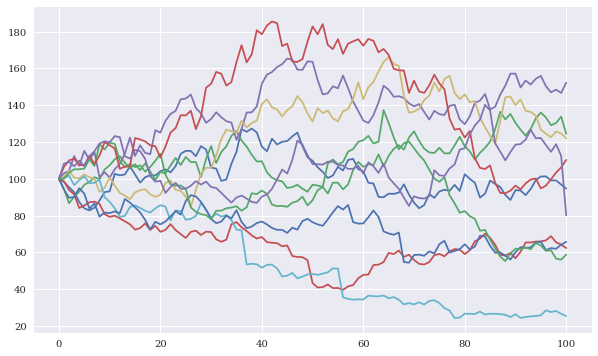

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(S);

As simple function to **value a European call option by MCS**.

In [42]:
def M76_value_call_MCS(K):
    return math.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I

In [43]:
%%time 
I = 200000
S = M76_generate_paths(S0, T, r, sigma, lamb, mu, delta, M, I)
print ("Value of Call Option %8.3f" % M76_value_call_MCS(K))

Value of Call Option   19.941
CPU times: user 4.27 s, sys: 1.32 s, total: 5.59 s
Wall time: 5 s


The model of Merton (1976) is capable of generating a **volatility smile**.

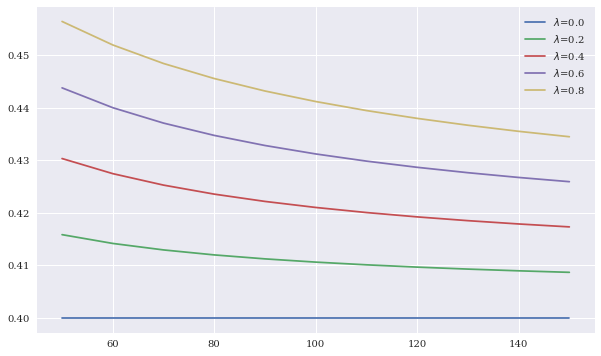

In [44]:
start = pd.Timestamp('2015-1-1')
end =  pd.Timestamp('2016-1-1')
strikes = range(50, 151, 10)
plt.figure(figsize=(10, 6))
for l in np.arange(0, 1.0, 0.2):
    imp_vols = []
    for k in strikes:
        call = call_option(S0, k, start, end, r, 0.2)
        M76_value = M76_value_call_INT(S0, k, T, r, sigma, l, mu, delta)
        imp_vols.append(call.imp_vol(M76_value))
    plt.plot(strikes, imp_vols, label='$\lambda$=%2.1f' % l)
plt.legend(loc=0); plt.savefig('vol_smile.png')

## Calibration of the Model

In simple terms, the problem of **calibration** is to find parameters for the Merton (1976) model such that observed market quotes of liquidly traded plain vanilla options are replicated as good as possible. To this end, one defines an error function that is to be minimized. Such a function could be the Root Mean Squared Error (RMSE). The task is then to solve the problem

$$
\min_{\sigma, \lambda, \mu_{J}, \delta } \sqrt{\frac{1}{N}\sum_{n=1}^{N}\left( C_{n}^{*} - C_{n}^{M76}(\sigma, \lambda, \mu_{J}, \delta )\right)^{2}}
$$
with the $C_{n}^{*}$ being the market or input prices and the $C_{n}^{M76}$ being the model or output prices for the options $n=1,...,N$.

**EXCURSION**: The minimization problem is ill-posed (I). Let's analyze properties of the error function for a single European call option.

In [45]:
C0 = M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta)
def error_function(p0):
    sigma, lamb, mu, delta = p0
    return abs(C0 - M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta))

**EXCURSION**: The minimization problem is ill-posed (II).

In [46]:
def plot_error_function():
    plt.figure(figsize=(10, 6))
    # Plotting (lamb)
    l = np.linspace(-0.5, 1.5, 100); EFv = []
    for i in l:
        EFv.append(error_function([sigma, i, mu, delta]))
    plt.plot(l, EFv, label='$\lambda$')
    plt.xlabel('parameter values')
    plt.ylabel('error function values c.p.')
    # Plotting (mu)
    l = np.linspace(-0.3, 0.3, 100); EFv = []
    for i in l:
        EFv.append(error_function([sigma, lamb, i, delta]))
    plt.plot(l, EFv, label='$\mu$')
    # Plotting (delta)
    l = np.linspace(-0.3, 0.3, 100); EFv = []
    for i in l:
        EFv.append(error_function([sigma, lamb, mu, i]))
    plt.plot(l, EFv, label='$\delta$')
    plt.legend(loc=0)

**EXCURSION**: The minimization problem is ill-posed (III).

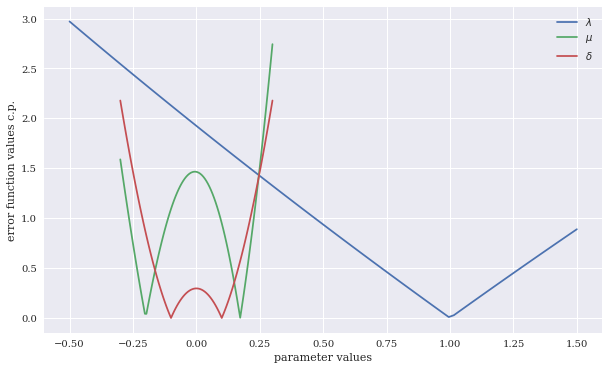

In [47]:
plot_error_function()

**EXCURSION**: The simple example illustrates that the calibration of the Merton (1976) jump diffusion model leads to a number of problems:


* **convexity**: the error function is only locally convex
* **determinacy**: the error function exhibits multiple minima
* **degeneracy**: different parameter combinations yield the same result
* **consistency**: the approach mathematically allows parameter values that are economically implausible
* **stability**: slight changes in the input values can change the solution significantly ('sudden' change from one local minimum to another is possible)

Let us import some **real option quotes for European call options on the EURO STOXX 50 index**.

In [48]:
import pandas as pd
h5 = pd.read_csv('http://hilpisch.com/es50_option_data.csv', index_col=0)
data['Date'] = data['Date'].apply(lambda x: pd.Timestamp(x))
data['Maturity'] = data['Maturity'].apply(lambda x: pd.Timestamp(x))

S0 = 3225.93  # EURO STOXX 50 level
r = 0.005  # assumption

# Option Selection
tol = 0.05
options = data[(np.abs(data['Strike'] - S0) / S0) < tol]
mats = sorted(set(options['Maturity']))
options = options[options['Maturity'] == mats[0]]

These are the **option quotes** we are dealing with (I).

In [49]:
options

,Date,Strike,Call,Maturity,Put,Imp_Vol
452,2014-09-30,3075.0,167.0,2014-10-17,9.3,0.272313
453,2014-09-30,3100.0,144.5,2014-10-17,11.7,0.255501
454,2014-09-30,3125.0,122.7,2014-10-17,14.9,0.239363
455,2014-09-30,3150.0,101.8,2014-10-17,19.1,0.223913
456,2014-09-30,3175.0,82.3,2014-10-17,24.5,0.210099
457,2014-09-30,3200.0,64.3,2014-10-17,31.5,0.197051
458,2014-09-30,3225.0,48.3,2014-10-17,40.5,0.185345
459,2014-09-30,3250.0,34.6,2014-10-17,51.8,0.174854
460,2014-09-30,3275.0,23.5,2014-10-17,65.8,0.165798
461,2014-09-30,3300.0,15.1,2014-10-17,82.3,0.158392


These are the **option quotes** we are dealing with (II).

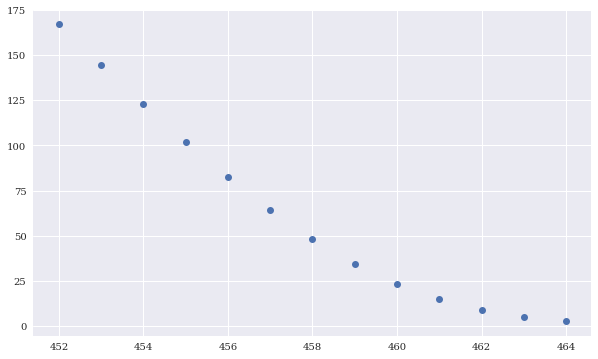

In [50]:
options['Call'].plot(style='o', figsize=(10, 6));

Next, we define an **error function** in Python for the calibration. 

In [51]:
i = 0; min_RMSE = 100.
def M76_error_function(p0):
    global i, min_RMSE
    sigma, lamb, mu, delta = p0
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = M76_value_call_INT(S0, option['Strike'], T,
                                         r, sigma, lamb, mu, delta)
        se.append((model_value - option['Call']) ** 2)
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 100 == 0:
        print ('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE

The calibration is done in two steps. First, a **global optimization**.

In [52]:
%%time
import scipy.optimize as sop
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%6.3f' % x})
p0 = sop.brute(M76_error_function, ((0.10, 0.201, 0.025),
                   (0.10, 0.80, 0.10), (-0.40, 0.01, 0.10),
                   (0.00, 0.121, 0.02)), finish=None)

   0 | [ 0.100  0.100 -0.400  0.000] |  12.676 |  12.676
 100 | [ 0.100  0.300  0.000  0.020] |  15.240 |   7.372
 200 | [ 0.100  0.600 -0.100  0.060] |  11.777 |   2.879
 300 | [ 0.125  0.200 -0.200  0.100] |   9.004 |   2.443
 400 | [ 0.125  0.500 -0.200  0.000] |   5.056 |   1.125
 500 | [ 0.150  0.100 -0.300  0.040] |   6.109 |   0.970
 600 | [ 0.150  0.400 -0.400  0.080] |   4.135 |   0.970
 700 | [ 0.150  0.600  0.000  0.120] |   6.333 |   0.970
 800 | [ 0.175  0.200  0.000  0.020] |   5.955 |   0.970
 900 | [ 0.175  0.500 -0.100  0.060] |   5.536 |   0.970
1000 | [ 0.200  0.100 -0.200  0.100] |   8.596 |   0.970
1100 | [ 0.200  0.400 -0.200  0.000] |  10.692 |   0.970
1200 | [ 0.200  0.700 -0.300  0.040] |  17.578 |   0.970
CPU times: user 1min 29s, sys: 729 ms, total: 1min 30s
Wall time: 1min 36s


Second, the **local (convex) optimization**.

In [53]:
%%time
opt = sop.fmin(M76_error_function, p0, xtol=0.00001,
                    ftol=0.00001, maxiter=750, maxfun=1500)

1300 | [ 0.122  0.723 -0.247  0.110] |   0.798 |   0.798
1400 | [ 0.119  1.001 -0.187  0.013] |   0.769 |   0.768
1500 | [ 0.119  1.031 -0.183  0.000] |   0.767 |   0.767
1600 | [ 0.119  1.033 -0.183  0.000] |   0.767 |   0.767
Optimization terminated successfully.
         Current function value: 0.766508
         Iterations: 278
         Function evaluations: 477
CPU times: user 32.2 s, sys: 388 ms, total: 32.5 s
Wall time: 36.3 s


The **optimal parameter values** are:

In [54]:
i = 0
M76_error_function(p0)

   0 | [ 0.125  0.600 -0.300  0.120] |   0.970 |   0.767


0.9695219560421178

In [55]:
i = 0
M76_error_function(opt)

   0 | [ 0.119  1.033 -0.183  0.000] |   0.767 |   0.767


0.7665083562548708

**Comparison** of market and model prices (I).

In [56]:
def generate_plot(opt, options):
    sigma, lamb, mu, delta = opt
    options['Model'] = 0.0
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        options.loc[row, 'Model'] = M76_value_call_INT(S0, option['Strike'],
                                    T, r, sigma, lamb, mu, delta)
    options = options.set_index('Strike')
    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 7))
    options[['Call', 'Model']].plot(style=['b-', 'ro'],
                    title='%s' % str(option['Maturity'])[:10], ax=ax[0])
    ax[0].set_ylabel('option values')
    xv = options.index.values
    ax[1] = plt.bar(xv - 5 / 2., options['Model'] - options['Call'], 
                    width=5)
    plt.ylabel('difference')
    plt.xlim(min(xv) - 10, max(xv) + 10)
    plt.tight_layout()

**Comparison** of market and model prices (II).

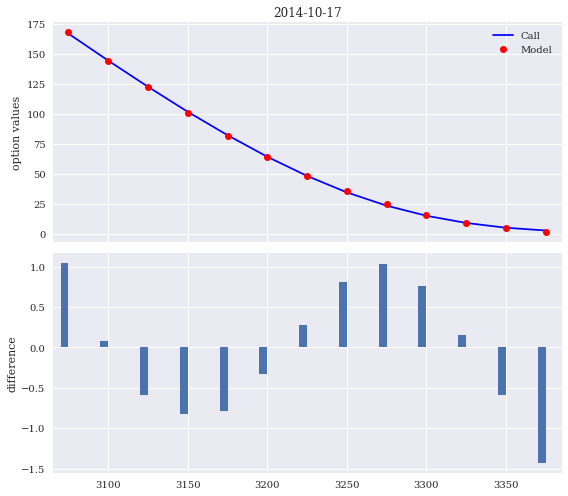

In [57]:
generate_plot(opt, options)

Finally, a look at the implied volatilities.

In [58]:
S0 = 3225.93; r = 0.005
def calc_imp_vols(data):
    data['Imp_Vol_Mod'] = 0.0
    data['Imp_Vol_Mar'] = 0.0
    tol = 0.30  # tolerance for moneyness
    for row in data.index:
        t = data['Date'][row]
        T = data['Maturity'][row]
        ttm = (T - t).days / 365.
        forward = np.exp(r * ttm) * S0
        if (abs(data['Strike'][row] - forward) / forward) < tol:
            call = call_option(S0, data['Strike'][row], t, T, r, 0.2)
            data['Imp_Vol_Mod'][row] = call.imp_vol(data['Model'][row])
            data['Imp_Vol_Mar'][row] = call.imp_vol(data['Call'][row])
    return data

The calculation of the **model implied volatilities** and a comparison.

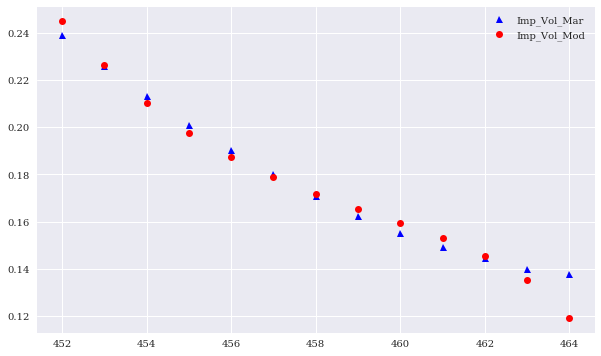

In [59]:
options = calc_imp_vols(options)
options[['Imp_Vol_Mar', 'Imp_Vol_Mod']].plot(figsize=(10, 6), style=['b^', 'ro'])

## Conclusions

In conclusion, we can state the following:

* **markets**: time series in financial markets strongly deviate from the Gaussian benchmark(s); there are generally eg stochastic volatility, jumps, implied volatility smiles observed in historical data
* **Merton (1976) model**: the model of Merton is capable of accounting for some observed stylized facts like jumps and volatility smiles
* **calibration issues**: numerical finance and optimization (i.e. calibration) faces a number of issues, eg with regard the determinacy of solutions and convexity of error functions
* **Python**: Python is really close to mathematical and financial syntax; the implementation of financial algorithms generally is efficient and performant (when using the right libraries and idioms like NumPy with vectorization)

All details, codes, proofs, etc. in the book "Derivatives Analytics with Python" &mdash; cf. [http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com).

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

**Training** |
<a href="http://training.tpq.io">http://training.tpq.io</a>

**Quant Platform** |
<a href="http://quant-platform.com">http://quant-platform.com</a>

**Python for Finance** |
<a href="http://python-for-finance.com" target="_blank">Python for Finance @ O'Reilly</a>

**Derivatives Analytics with Python** |
<a href="http://derivatives-analytics-with-python.com" target="_blank">Derivatives Analytics @ Wiley Finance</a>